# 프로젝트: 퍼스널 컬러 진단 - VGG16

## 데이터
1. 유명인 웜톤 100장, 쿨톤 100장  
2. 일반인 웜톤 490장, 쿨톤 186장  

## 목표: VGG16 아키텍처에 퍼스널컬러 적용하기  
참고 링크:https://eremo2002.tistory.com/55   

## 모델 환경
1. VGG16의 마지막 Dense layer 부분은 추가 수정함  
2. 이진 분류이지만 웜/쿨 확률 출력을 위하여 softmax(마지막 layer 2개) 사용  
3. 2번에 따라서 컴파일은 optimazir = adam, loss = sparse_categorical_corssentropy, metrics = accuracy  

## (1) 라이브러리 및 데이터 불러오기

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import vgg16

import numpy as np
import cv2
import os
import glob
from PIL import Image
import random

In [30]:
# 1번: warm_1 238 + cool_1 238 = 476
# 2번: warm_1 238 + warm_2 336 + cool_1 238 + cool_2 336 = 1148
# 3번: warm_1 740 + cool_1 238 = 978
# 4번: warm_1 740 + cool_1 238 + warm_2 2307 + cool_2 336 = 3621

def load_data(img_path, number_of_data=978):  
    # 웜톤 : 0, 쿨톤 : 1
    img_size=224
    color=3
    #이미지 데이터와 라벨(웜톤 : 0, 쿨톤 : 1) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0    
    
    warm1_files = list(glob.iglob(img_path + '/warm_1/*.jpg')) + list(glob.iglob(img_path + '/warm_1/*.JPG'))
#     warm2_files = list(glob.iglob(img_path + '/warm_2/*.jpg')) + list(glob.iglob(img_path + '/warm_2/*.JPG'))

    # 각 디렉토리에서 무작위로 선택
    warm1_files = random.sample(warm1_files, 740)
#     warm2_files = random.sample(warm2_files, 336)

    # 두 리스트를 합침
    warm_files = warm1_files 
#     + warm2_files

    for file in warm_files:
        img = Image.open(file)  # 이미지 열기
        img = img.resize((img_size, img_size))  # 이미지 크기 조정
        img = np.array(img, dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 웜톤 : 0
        idx=idx+1

                
    cool_files = (list(glob.iglob(img_path + '/cool_1/*.jpg')) + list(glob.iglob(img_path + '/cool_1/*.JPG')))
#               + list(glob.iglob(img_path + '/cool_2/*.jpg')) + list(glob.iglob(img_path + '/cool_2/*.JPG')))
    
    for file in cool_files:
        img = Image.open(file)  # 이미지 열기
        img = img.resize((img_size, img_size))  # 이미지 크기 조정
        img = np.array(img, dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 쿨톤 : 1
        idx=idx+1  
    
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/project/first-repository/data/DataSet_final/content/drive/MyDrive/사계절_연예인 이미지 데이터셋/train data"
(x_train, y_train)=load_data(image_dir_path)

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 978 입니다.
x_train shape: (978, 224, 224, 3)
y_train shape: (978,)


In [13]:
# 0. 필요한 함수 import
import os
from glob import glob
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

#1. 데이터 파일 경로찾기
train_dir = '/aiffel/aiffel/project/first-repository/data/DataSet_final/content/drive/MyDrive/사계절_연예인 이미지 데이터셋/train data'

#2. Set Data Generator

# Corrected import statement
import tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#datagenerator 생성
train_datagenerator = ImageDataGenerator(
	rescale = 1./255.,
    width_shift_range = 0.3,
    zoom_range = 0.7,
    horizontal_flip = True
)

#train_datagenerator을 train image에 적용
train_result = train_datagenerator.flow_from_directory(
	train_dir, 
    batch_size = 42,
    class_mode='sparse',  # binary_crossentropy 손실 함수를 사용하므로 binary 형태로 라벨을 불러와야 합니다.
    seed = 42
)

#3. model 생성 후, 
inputs = layers.Input(input_shape)
net = layers.Conv2D(32, 3, padding = 'SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, 3, padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size = 2)(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, 3, padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, 3, padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size = 2)(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs = inputs, outputs = net, name = 'Basic_CNN')

model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), #Optimization
             loss = 'spars_categorical_crossentropy', #Loss function
             metrics = ['accuracy']) #Metrics/Accuracy
#4. Training
model.fit_generator(
    train_generator, 
    steps_per_epoch = len(train_generator), 
    epochs = 10)
#steps_per_epoch : 한 epoch에 몇 개의 묶음의 이미지(batch)가 epoch에 돌아갈지


Found 3621 images belonging to 4 classes.


NameError: name 'input_shape' is not defined

## (2) 데이터 전처리

In [31]:
x_train = x_train / 255.0 #정규화

## (3) train, val 분리하기

In [32]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.3,
                                                  random_state=42)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (684, 224, 224, 3)
y_train:  (684,)
x_val:  (294, 224, 224, 3)
y_val:  (294,)


In [33]:
# from keras.preprocessing.image import ImageDataGenerator

# # 이미지 증강을 위한 ImageDataGenerator 생성
# datagen = ImageDataGenerator(
#     rescale=1./255, 
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # 증강할 데이터 수 적기
# augmented_size = 4000

# # 원래 데이터셋으로부터 이미지 증강 적용하여 증강된 이미지를 생성하고 추가
# augmented_images = []
# augmented_labels = []

# # 이미지 증강 적용하여 증강된 이미지를 생성하고 추가
# for i in range(augmented_size):
#     for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=len(x_train)):
#         augmented_images.append(x_batch)
#         augmented_labels.append(y_batch)
        

# # 증강된 이미지들을 원래 데이터셋에 추가
# x_train_augmented = np.concatenate([x_train] + augmented_images, axis=0)
# y_train_augmented = np.concatenate([y_train] + augmented_labels, axis=0)

# # 최종 증강된 데이터셋의 개수 확인
# print("최종 증강된 데이터셋 개수:", len(x_train_augmented))
# print(len(augmented_images))

In [34]:
# 데이터를 텐서로 변환(데이터 증강 시 없어도 되는 코드)
# x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
# x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
# y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
# y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)

## (4) 모델 정의 및 컴파일

In [51]:
from keras.models import Model
from keras import Input
from keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [52]:
learning_rate = 0.0001

adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    './check/VGG16(아키텍처)/3번/3-1/model_{epoch:02d}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',    
)
# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [53]:
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(x_val, y_val),
                   callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/50
11/11 [==============================] - 53s 3s/step - loss: 0.5993 - accuracy: 0.7602 - val_loss: 0.5814 - val_accuracy: 0.7483

Epoch 00001: val_loss improved from inf to 0.58137, saving model to ./check/VGG16(아키텍처)/3번/3-1/model_01.h5
Epoch 2/50
11/11 [==============================] - 10s 926ms/step - loss: 0.5325 - accuracy: 0.7602 - val_loss: 0.4729 - val_accuracy: 0.7483

Epoch 00002: val_loss improved from 0.58137 to 0.47294, saving model to ./check/VGG16(아키텍처)/3번/3-1/model_02.h5
Epoch 3/50
11/11 [==============================] - 10s 927ms/step - loss: 0.4112 - accuracy: 0.7982 - val_loss: 0.3847 - val_accuracy: 0.8265

Epoch 00003: val_loss improved from 0.47294 to 0.38470, saving model to ./check/VGG16(아키텍처)/3번/3-1/model_03.h5
Epoch 4/50
11/11 [==============================] - 10s 944ms/step - loss: 0.3829 - accuracy: 0.8158 - val_loss: 0.4029 - val_accuracy: 0.8061

Epoch 00004: val_loss did not improve from 0.38470
Epoch 5/50
11/11 [=============================

## (6) 예측하기

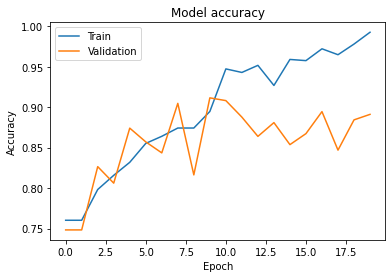

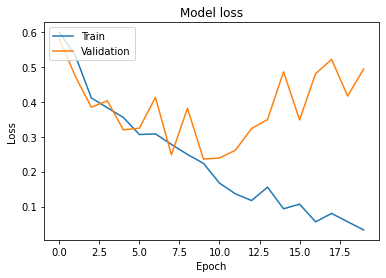

In [54]:
import matplotlib.pyplot as plt

# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [55]:
# checkpoint로 저장한 모델 불러올 때
from tensorflow.keras.models import load_model

# 체크포인트 파일의 경로를 지정합니다.
checkpoint_filepath = './check/VGG16(아키텍처)/3번/3-1/model_10.h5'

# 체크포인트에 저장된 모델을 로드합니다.
model = load_model(checkpoint_filepath)

pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

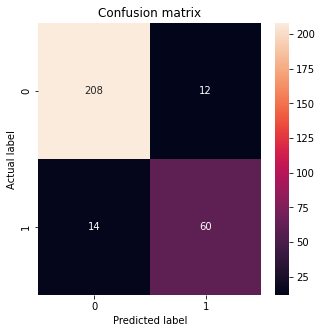

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [57]:
print(pred_class)
print(y_val)
print(pred)

[0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0
 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0
 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0
 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1]
[0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0
 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0
 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 1 0 0 0 1 0 1 0 1 1 1 1 0

In [58]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.911565


In [59]:
from sklearn.metrics import classification_report

print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       220
           1       0.83      0.81      0.82        74

    accuracy                           0.91       294
   macro avg       0.89      0.88      0.88       294
weighted avg       0.91      0.91      0.91       294



### - 아키텍처를 간소화시키고 learning_rate를 조절하니 값이 다양하게 나오고 정확도가 0.3 -> 0.6까지 올랐다  
- 유명인 100장 시도  
1차 시도: 0.63(77)  
2차 시도: 40(99)  
3차 시도: 0.37(33)  
4차 시도: 0.53(316)  
- 데이터를 바꾸니까 0.6 -> 0.9까지 올랐다  
- 알반인 200장 시도  
1차 시도: 0.92(316)  
2차 시도: 0.65(99)  
3차 시도: 0.82(1004)  
4차 시도: 0.75(42)  
- 다시 VGG16의 본래 아키텍처로 다시 시도 (learning rate는 그대로 1e-6)  
1차 시도: 0.52(42)  
2차 시도: 0.35(55)  
3차 시도: 0.47(1004)  
4차 시도: 0.45(316)  
 -> 다시 기울기를 잃는 모습을 확인할 수 있다 그러므로 깊이를 축소시키는게 답이었다  
 -> 원핫인코딩으로 바꾸고 이진분류 손실함수로 바꾸고 softmax를 sigmoid로 바꾸었지만 기존의 아키텍처로는 예측값이 계속 0 혹은 1로만 나오는 것을 알 수 있다.  
 
- 기존의 아키텍처에서도 데이터량을 늘리고 옵티마이저의 learning rate를 변경하였을 때 잘 작동하는 것을 확인할 수 있었다.   

## (7) TEST

In [ ]:
def load_data(img_path, number_of_data=100):  
    # 웜톤 : 0, 쿨톤 : 1
    img_size=224
    color=3
    #이미지 데이터와 라벨(웜톤 : 0, 쿨톤 : 1) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0    
    
    warm_files = list(glob.iglob(img_path + '/warm/*.jpg')) + list(glob.iglob(img_path + '/warm/*.JPG'))
    
    for file in warm_files:
        img = Image.open(file)  # 이미지 열기
        img = img.resize((img_size, img_size))  # 이미지 크기 조정
        img = np.array(img, dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 웜톤 : 0
        idx=idx+1

                
    cool_files = (list(glob.iglob(img_path + '/cool/*.jpg')) + list(glob.iglob(img_path + '/cool/*.JPG')))
    
    for file in cool_files:
        img = Image.open(file)  # 이미지 열기
        img = img.resize((img_size, img_size))  # 이미지 크기 조정
        img = np.array(img, dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 쿨톤 : 1
        idx=idx+1  
    
    print("평가데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/project/first-repository/data/DataSet_final/content/drive/MyDrive/사계절_연예인 이미지 데이터셋"
(x_test, y_test)=load_data(image_dir_path)

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

In [ ]:
# checkpoint로 저장한 모델 불러올 때
from tensorflow.keras.models import load_model

# 체크포인트 파일의 경로를 지정합니다.
checkpoint_filepath = './check/VGG16(아키텍처)/2번/1-1/model_.h5'

# 체크포인트에 저장된 모델을 로드합니다.
model = load_model(checkpoint_filepath)

pred = model.predict(x_test)
pred_class = np.argmax(pred, axis=1)
print(pred_class)

In [ ]:
acc = np.mean(pred_class == y_test)
print('accuracy: %f' % (acc,))

In [2]:
자동레이블링vs수동레이블링vs모델예측

1. 자동레이블링 vs 모델예측 -> 정확도 웜 쿨 -> lab vs 딥러닝 90% ->얘는 이미 높게 나올 것임
2. 수동레이블링 vs 모델예측 -> 정확도 쿨 쿨 -> 사람 vs 딥러닝 80%(기도메타, 중요)
3. 자동레이블링 vs 수동레이블링 -> 정확도 웜 쿨 -> lab vs 사람 -> 자동레이블링을 한 것의 신뢰도 주장(기도메타)
80%

1.어떤 조명이 있든 고유의 색을 본다! 
= 조명을 없앤다고 가정하고 조명이 어둡든 밝든 같은 사람에 대해 같은 톤!! 
(우리의 초기 레이블링)

2. 특정한 상황에서만 촬영된 사진!
= 조명색이 달라짐에 따라 같은 사람이 쿨톤이 될수도 웜톤이 될 수도 있다!!
(오늘 우리 한 레이블링) -> 사용자에게 설정해야함 "빛이 고른 곳에서 찍은 사진을 업로드 해주세요~"

SyntaxError: invalid syntax (1116953333.py, line 3)

In [33]:
class_name = ["웜톤", "쿨톤"]

In [53]:
# test 불러오기 (낱개 버전)
test_path = "/aiffel/aiffel/project/first-repository/data/four_seasons/TEST/박은빈.jpg"
x_test = Image.open(test_path)
x_test = np.array(x_test)
print(x_test.shape)

# 배열의 크기 변환
x_test = x_test.reshape((1, x_test.shape[0], x_test.shape[1], 3))
print("변환된 배열 크기:", x_test.shape)

# 전처리(resize, 정규화)
x_test = preprocess_image(x_test)
print(x_test.shape)

# 만약 앱구현과 연결된다면 저장된 모델을 다시 돌릴 필요없이 저장된 최적의 모델을 사용하도록 수정해야함
# test
pred = model.predict(x_test)
pred_class = np.argmax(pred, axis=1)
print("당신은", class_name[int(pred_class)], "입니다~!")
print("웜톤일 확률: ", np.round(pred[:, 0], 3))
print("쿨톤일 확률: ", np.round(pred[:, 1], 3))

(275, 183, 3)
변환된 배열 크기: (1, 275, 183, 3)
(1, 224, 224, 3)
당신은 쿨톤 입니다~!
웜톤일 확률:  [0.005]
쿨톤일 확률:  [0.995]


In [159]:
# 박은빈 쿨톤, 강혜원 웜톤 맞춤!!